# Szegedy’s quantum walk with queries (Santos, 2016)

Implementation of the algorithm described in [this paper](https://link.springer.com/article/10.1007/s11128-016-1427-4).

## Import libraries

In [244]:
import pennylane as qml
import pennylane.numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

In [245]:
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=3, suppress=True)
qml.__version__

'0.41.1'

## 2 Szegedy's Quatum Walk

In [246]:
N = 45 # dimension of the graph
n = int(np.ceil(np.log2(N))) # dimension of the associated Hilbert space
print(f"N = {N}")
print(f"n = {n}")

N = 45
n = 6


### Stochastic matrices

![Complete graph with m=5, n=1](complete_graph_m1.PNG "Complete graph with m=5, n=1")

#### $P'$

In [247]:
def generate_P_mat(N, absorbing=False, m=0):
    n = int(np.ceil(np.log2(N)))
    P = block_diag(1/(N-1) * (np.ones(N) - np.eye(N)), np.eye(2**n-N))
    # absorbing RW
    if (absorbing):
        for i in range(N):
            P[m-1, i] = 0
        P[m-1, m-1] = 1
    return P

In [248]:
m = 5
P = generate_P_mat(N, absorbing=True, m=m)
# print(P)

#### $R_A$

In [249]:
def generate_RA(n, P):
    RA = np.zeros((2**(2*n), 2**(2*n)))

    for x in range(2**n):
        phi = np.zeros((2**(2*n), 1))
        ket_x = np.zeros((2**n, 1))
        ket_x[x] = 1
        for y in range(2**n):
            ket_y = np.zeros((2**n, 1))
            ket_y[y] = np.sqrt(P[x][y])
            phi += np.kron(ket_x, ket_y) # x⊗y
        # print(f"x={x}")
        # print(np.sum(phi**2)) # norm-square: should be one for a "valid" quantum state
        # print(phi.T)   
        RA += np.dot(phi, phi.T)    
    RA = 2 * RA - np.eye(2**(2*n))
    return RA

In [250]:
RA = generate_RA(n, P)
print(RA.shape)
# print(RA)
print(r'Is $R_A$ unitary (left)?', np.all(np.allclose(np.dot(RA, RA.T), np.eye(2**(2*n)))))
print(r'Is $R_A$ unitary (right)?', np.all(np.allclose(np.dot(RA.T, RA), np.eye(2**(2*n)))))

(4096, 4096)
Is $R_A$ unitary (left)? True
Is $R_A$ unitary (right)? True


#### $R_B$

In [251]:
def generate_RB(n, P):
    RB = np.zeros((2**(2*n), 2**(2*n)))

    for y in range(2**n):
        psi = np.zeros((2**(2*n), 1))
        ket_y = np.zeros((2**n, 1))
        ket_y[y] = 1
        for x in range(2**n):
            ket_x = np.zeros((2**n, 1))
            ket_x[x] = np.sqrt(P[y][x])
            psi += np.kron(ket_x, ket_y) # y⊗x
        RB += np.dot(psi, psi.T)    
    RB = 2 * RB - np.eye(2**(2*n))
    return RB

In [252]:
RB = generate_RB(n, P)
print(RB.shape)
# print(RB)
# print(np.dot(RB, RB.T))
print('Is RB unitary (left)?', np.all(np.allclose(np.dot(RB, RB.T), np.eye(2**(2*n)))))
print('Is RB unitary (right)?', np.all(np.allclose(np.dot(RB.T, RB), np.eye(2**(2*n)))))

(4096, 4096)
Is RB unitary (left)? True
Is RB unitary (right)? True


### Searching

$\ket\psi$ is introduced earlier in the paper as the initial state of the walker. However, the state $\ket\psi$ not only reproduces the walker trend more faithfully but also yields a higher probability of measurement for $\sum_y\ket{m, y}$.

In [253]:
# # initial state
# psi = np.zeros((2**(2*n)))
# for x in range(N):
#     ket_x = np.zeros((2**n))
#     ket_x[x] = 1
#     for y in range(N):
#         ket_y = np.zeros((2**n))
#         ket_y[y] += np.sqrt(P[x][y])
#         psi += np.kron(ket_x, ket_y)    
# psi /= np.sqrt(N)
# # print(psi)
# print("Is the statevector valid?", qml.math.isclose(qml.math.norm(np.sum(psi**2)), 1))

In [254]:
# initial state
phi = np.zeros((2**(2*n)))
for x in range(N):
    ket_x = np.zeros((2**n))
    ket_x[x] = 1
    for y in range(N):
        if y==x:
            continue
        ket_y = np.zeros((2**n))
        ket_y[y] += 1/np.sqrt(N-1)
        phi += np.kron(ket_x, ket_y)    
phi /= np.sqrt(N)
# print(phi)
print("Is the statevector valid?", qml.math.isclose(qml.math.norm(np.sum(phi**2)), 1))

Is the statevector valid? True


In [255]:
Up = np.dot(RB, RA) # marked walk operator
np.allclose(Up, Up.T) 

False

### Quantum circuit

In [256]:
num_qubits = 2*n
# Create a device for simulation
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def circuit(steps):
    qml.StatePrep(phi, wires=range(num_qubits))
    # [qml.Hadamard(i) for i in range(num_qubits)]
    for _ in range(steps):
        # Apply the unitary matrix
        qml.QubitUnitary(Up, wires=range(num_qubits), id=r"$U_p$")
    # Measure all qubits
    return qml.state()

(<Figure size 700x1300 with 1 Axes>, <Axes: >)

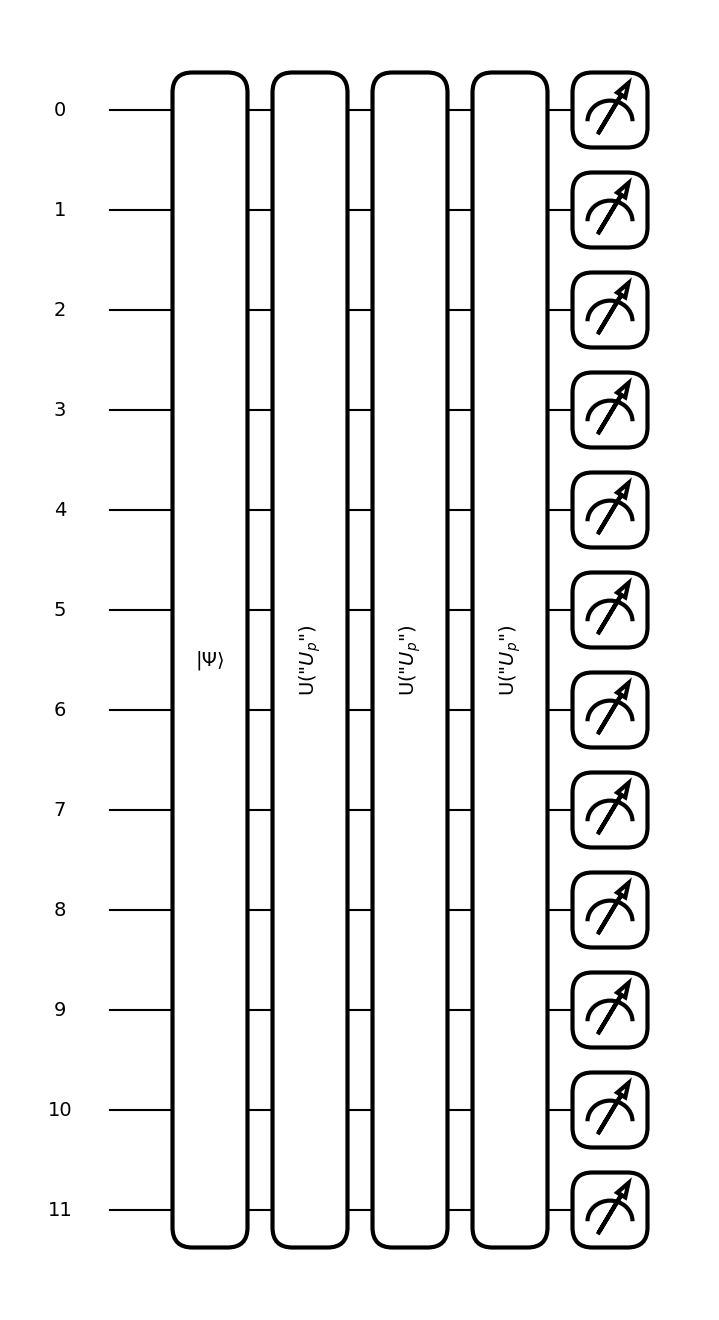

In [257]:
# draw a sample quantum circuit
qml.draw_mpl(circuit)(3)

In [258]:
# data arrays
m_data = []

# Execute the circuit
print("Steps\tsum_pm")
print("---------------")
steps = int(np.ceil(2*np.pi*N**0.5))
for k in range(steps+1):
    state_vector = np.abs(circuit(k)**2)
    sum_pm = np.sum(state_vector[(m-1)*2**n:(m)*2**n])
    # sum_pm = 0
    # for i in range(N):
    #     if i==m-1:
    #         continue
    #     sum_pm += state_vector[2**n*i+(m-1)] 
    m_data.append(sum_pm) 
    max_index = qml.math.argmax(state_vector)
    print(f"{k}\t{sum_pm:.3f}")

Steps	sum_pm
---------------
0	0.022
1	0.188
2	0.427
3	0.592
4	0.577
5	0.393
6	0.156
7	0.011
8	0.036
9	0.192
10	0.354
11	0.397
12	0.291
13	0.115
14	0.004
15	0.056
16	0.257
17	0.489
18	0.608
19	0.537
20	0.323
21	0.099
22	0.000
23	0.073
24	0.245
25	0.382
26	0.380
27	0.241
28	0.070
29	0.001
30	0.103
31	0.328
32	0.541
33	0.607
34	0.485
35	0.251
36	0.052
37	0.005
38	0.119
39	0.295
40	0.398
41	0.351
42	0.188
43	0.034


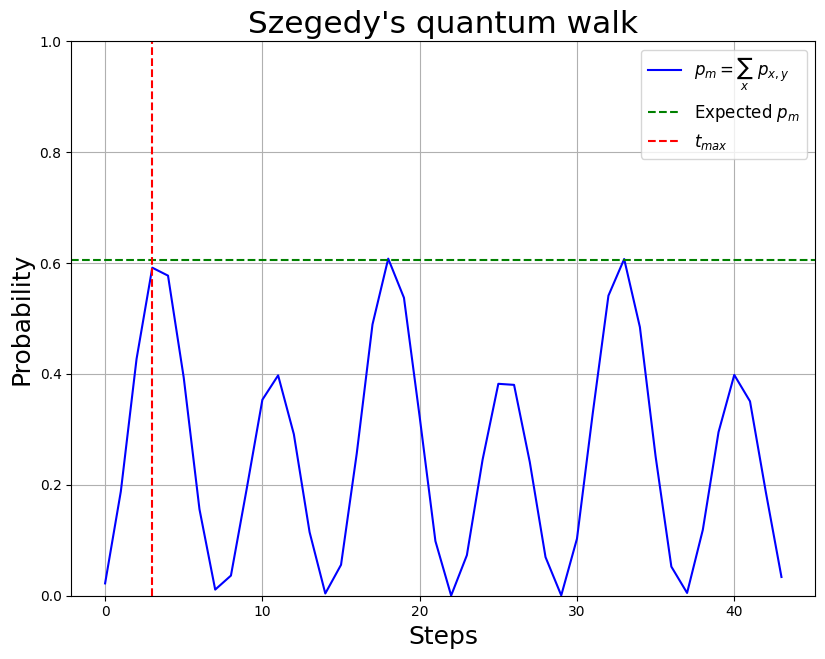

In [259]:
scale_factor = 1.5
default_figsize = plt.rcParams["figure.figsize"]
scaled_figsize = (default_figsize[0] * scale_factor, default_figsize[1] * scale_factor)

plt.figure(figsize=scaled_figsize)
plt.plot(range(steps+1), m_data, "b-", label=r"$p_m = \sum_x~p_{x,y}$")
plt.axhline(y=0.5 + 1/np.sqrt(2*N), color="green", linestyle="--", label=r"Expected $p_m$")
plt.axvline(x=int(np.round(np.pi/4*np.sqrt(N/2)-1/4)), color="red", linestyle="--", label=r"$t_{max}$")
plt.legend(fontsize=12, loc="upper right")
plt.title("Szegedy's quantum walk", fontsize=15*scale_factor)
plt.xlabel("Steps", fontsize=12*scale_factor)
plt.ylabel("Probability", fontsize=12*scale_factor)
plt.ylim((0, 1))
plt.grid()
plt.show()

In [260]:
print(f"m     = {np.argmax(m_data)}\np(m)  = {np.max(m_data)}")
print(f"p'(m) = {0.5 + 1/np.sqrt(2*N)}")

m     = 18
p(m)  = 0.6080244398774373
p'(m) = 0.605409255338946


## 3 Szegedy's Quantum Walk with Queries

In [261]:
M = [5]
for x in M:
    if x > N:
        raise ValueError(f"Node '{x}' is not in the graph.")

In [262]:
RM = np.zeros((2**n, 2**n))
for i in M:
    x = np.zeros((2**n, 1))
    x[i-1] = 1
    RM += np.dot(x, x.T)

RM = np.eye(2**n) - 2 * RM
# print(RM)
RM = np.kron(RM, np.eye(2**n))
print(RM.shape)

(4096, 4096)


> **Note:** The $m$<sup>th</sup> diiagonal element is $-1$ instead of $1$. This is phase-tagging (a loosely used term) of the required vertices.

In [263]:
P = generate_P_mat(N)
RA = generate_RA(n, P)
RB = generate_RB(n, P)

Up = np.dot(RB, np.dot(RA, RM))

In [264]:
# initial state
phi = np.zeros((2**(2*n)))

# |a,a>
for x in range(N):
    if (x+1) in M:
        continue
    ket_x = np.zeros((2**n))
    ket_x[x] = 1
    for y in range(N):
        if (y+1) in M:
            continue
        if (y==x):
            continue
        ket_y = np.zeros((2**n))
        ket_y[y] += 1
        phi += np.kron(ket_x, ket_y)/np.sqrt((N-1))    
# |a, b>
b = M[0]-1
ket_b = np.zeros((2**n))
ket_b[b] = 1
for x in range(N):
    if (x+1) in M:
        continue
    ket_x = np.zeros((2**n))
    ket_x[x] = 1
    phi += np.kron(ket_x, ket_b)/np.sqrt(N-1) 

# |b, a>
for y in range(N):
    if (y+1) in M:
        continue
    ket_y = np.zeros((2**n))
    ket_y[y] = 1
    phi += np.kron(ket_b, ket_y)/np.sqrt(N-1) 

phi /= np.sqrt(N)
phi_norm = qml.math.norm(np.sum(phi**2))
print(phi_norm)
print("Is the statevector valid?", qml.math.isclose(phi_norm, 1))

0.9999999999999998
Is the statevector valid? True


In [265]:
num_qubits = 2*n
# Create a device for simulation
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def circuit(steps):
    qml.StatePrep(phi, wires=range(num_qubits))
    # [qml.Hadamard(i) for i in range(num_qubits)]
    for _ in range(steps):
        # Apply the unitary matrix
        qml.QubitUnitary(Up, wires=range(num_qubits), id=r"$U_p$")
    # Measure all qubits
    return qml.state()

In [266]:
# data arrays
m_data_RM = []

# Execute the circuit
print("Steps\tsum_pm")
print("---------------")
steps = int(np.ceil(2*np.pi*N**0.5))
for k in range(steps+1):
    for m in M:
        state_vector = np.abs(circuit(k)**2)
        sum_pm = np.sum(state_vector[(m-1)*2**n:(m)*2**n])
    # sum_pm = 0
    # for i in range(N):
    #     if i==m-1:
    #         continue
    #     sum_pm += state_vector[2**n*i+(m-1)] 
    m_data_RM.append(sum_pm) 
    max_index = qml.math.argmax(state_vector)
    print(f"{k}\t{sum_pm:.3f}")

Steps	sum_pm
---------------
0	0.022
1	0.188
2	0.462
3	0.749
4	0.950
5	0.994
6	0.866
7	0.611
8	0.317
9	0.087
10	0.000
11	0.087
12	0.317
13	0.611
14	0.866
15	0.994
16	0.950
17	0.750
18	0.463
19	0.189
20	0.022
21	0.022
22	0.188
23	0.462
24	0.749
25	0.950
26	0.994
27	0.866
28	0.612
29	0.318
30	0.087
31	0.000
32	0.086
33	0.317
34	0.610
35	0.866
36	0.994
37	0.950
38	0.750
39	0.463
40	0.189
41	0.022
42	0.022
43	0.187


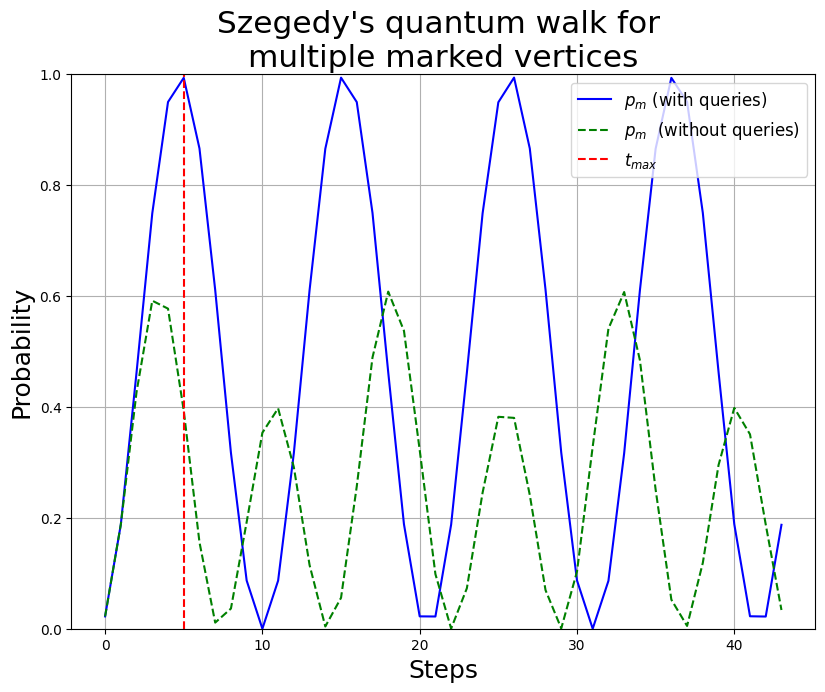

In [267]:
scale_factor = 1.5
default_figsize = plt.rcParams["figure.figsize"]
scaled_figsize = (default_figsize[0] * scale_factor, default_figsize[1] * scale_factor)

plt.figure(figsize=scaled_figsize)
plt.plot(range(steps+1), m_data_RM, "b-", label=r"$p_m$ (with queries)")
plt.plot(range(steps+1), m_data, "g--", label=r"$p_m$  (without queries)")
# plt.axhline(y=0.5 + 1/np.sqrt(2*N), color="green", linestyle="--", label=r"Expected $p_m$")
plt.axvline(x=int(np.round(np.pi/4*np.sqrt(N/len(M)))), color="red", linestyle="--", label=r"$t_{max}$")
plt.legend(fontsize=12, loc="upper right")
plt.title("Szegedy's quantum walk for \nmultiple marked vertices", fontsize=15*scale_factor)
plt.xlabel("Steps", fontsize=12*scale_factor)
plt.ylabel("Probability", fontsize=12*scale_factor)
plt.ylim((0, 1))
plt.grid()
plt.show()

> **Note:**  A noticeable trend is the decrease in $p_m$ with an increase in the number of graph nodes $N$ in section 2 and an increase in $p_m$ in section 3 ($p_m \approx 0.9$ for $N=5$).